<u>**ATTENTION FROM SCRATCH**</u>

This notebook provides a step by step walkthrough for how implement a single head of self-attention from the scratch using pytorch.

inspired by Karpathy's transformer tutorial: https://www.youtube.com/watch?v=kCc8FmEb1nY&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=7

*core problem*: how to gather information from the past in a data-dependent way?

<u>**DEFINITIONS**</u>

**B**: batch size (numner of examples in a training batch, processed in parallel)

**T**: time (context length, number of tokens per batch example)

**C**: channels (embedding dimension, number of elements used to represent each token)

In [1]:
import torch

torch.manual_seed(42) # for reproducibility
B, T, C = 4, 8, 2 # batch size, time steps, channels
x = torch.rand(B, T, C) # input

**VERSION 1**

<u>Objective</u>: create random input **x**, and then calculate **out**, which is an identically sized tensor containing the average of all the proceeding tokens for a given exmample

In [2]:
# do computation

xbow1 = torch.zeros(B, T, C) # pre-allocate output
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1, ] # all previous time steps (t, C)
        xprev_mean = torch.mean(xprev, dim=0) # average over time (C)
        xbow1[b, t] = xprev_mean # average over time (C)


In [3]:
# evaluate output

print(f'{x.shape = }')
print(f'{xbow1.shape = }')

print(f'{x[0,:3] = }')
print(f'{xbow1[0,:3] = }')

x.shape = torch.Size([4, 8, 2])
xbow1.shape = torch.Size([4, 8, 2])
x[0,:3] = tensor([[0.8823, 0.9150],
        [0.3829, 0.9593],
        [0.3904, 0.6009]])
xbow1[0,:3] = tensor([[0.8823, 0.9150],
        [0.6326, 0.9372],
        [0.5519, 0.8251]])


<u>Evaluation</u>: as shown above, for the first 3 timesteps of the first batch, the output matches our objective. For the first token, both output channels match the input channels (mean over one sample). For the next token, the output channel is the mean of the first two input channels, etc...

For the next two versions, we'll verify the results by comparing against this output.

**VERSION 2**

<u>Objective</u>: Same as above, but do it more efficiently using matrix multiplication. This allows us to do an average aggregation of past information (no future) using a lower triangular matrix multiply

In [4]:
# do computation 

wei = torch.tril(torch.ones(T, T)) # lower triangular matrix (T, T)

# dim=1 means "reduce over column dimension"
# keepdim=True is critical, because it maintains the empty column dimension which is needed for broadcasting (see tangent below)
wei = wei / wei.sum(dim=1, keepdim=True) # normalize (T, T)
xbow2 = wei @ x # matrix multiplication (T, T) @ (B, T, C) -> (B, T, C); broadcast (T, T) over batch dimension B and then do (T, T) @ (T, C) for each batch in parallel
print(wei)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [5]:
# evaluate output

torch.allclose(xbow1, xbow2) # check that outputs are equal

True

**VERSION 3**

<u>Objective</u>: Same as above, but introduce softmax to now allow for *weighted* aggregation of past information. Here we're still doing an average, but introducing softmax allows us to handle non uniform weight distributions in the future...

In [6]:
# do computation 

tril = torch.tril(torch.ones(T, T)) # lower triangular matrix (T, T)
wei = torch.zeros(T, T) # weight matrix (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # mask out upper triangular part (T, T)
print("before softmax: \n", wei)
wei = torch.softmax(wei, dim=1) # softmax over column dimension (T, T)
print("after softmax: \n", wei)
xbow3 = wei @ x # matrix multiplication (T, T) @ (B, T, C) -> (B, T, C); broadcast (T, T) over batch dimension B and then do (T, T) @ (T, C) for each batch in parallel

before softmax: 
 tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
after softmax: 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.125

In [7]:
# evaluate output

torch.allclose(xbow1, xbow3) # check that outputs are equal

True

<u>**VERSION 4: SELF ATTENTION**</u>

<u>Objective</u>: Implement a single head of self attention. Here, each token emits three vectors of length *head_size*:

1. query: "what am I looking for?"

2. key: "what I contain"

3. value: "what I will communicate"

weight matrix contains the affinities for each token with respect to all other tokens in the example. for a given token_1, it's affinity to any other token_x in the example is calculated via a dot product between token_1's query and token_x's key. we scale this up with matrix multiplication to compute the affinities between all tokens for an example and across batches in parallel. the weight matrix is then normalized and future info is omitted via masking and softmax.

output is then determined via matrix multiplication between the weight matrix and the value matrix. 

we can think of the input *x* as containing private information. it only communicates outwardly via query, key, and value, which are all calculated via a linear layer that transforms each token in x from *C* -> *head_size*



In [8]:
import torch.nn as nn
import torch.nn.functional as F

head_size = 16

# linear layers used to project *private* input into *public* key, query, and value vectors
query = nn.Linear(C, head_size, bias=False) # converts (B, T, C) -> (B, T, head_size)
key = nn.Linear(C, head_size, bias=False) # converts (B, T, C) -> (B, T, head_size)
value = nn.Linear(C, head_size, bias=False) # converts (B, T, C) -> (B, T, head_size)

q = query(x) # (B, T, head_size) 
k = key(x) # (B, T, head_size) NOTE: here we implement *self* attention bc k is derived from the input; but in *cross-attention*, this would come from elsewhere (the encoder, not this input)
v = value(x) # (B, T, head_size) NOTE: here we implement *self* attention bc v is derived from the input; but in *cross-attention*, this would come from elsewhere (the encoder, not this input)

wei = q @ k.transpose(-1, -2) * head_size**-0.5 # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)

# mask to eliminate future info and normalize via softmax
tril = torch.tril(torch.ones(T, T)) # lower triangular matrix (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # mask out upper triangular part (B, T, T), broadcast over batch dimension B NOTE: this implements a *decoder* bc we ignore the future; if we wanted to implement an *encoder*, we would not mask out any of this info
wei = F.softmax(wei, dim=-1) # softmax over last dimension (T, T)

out = wei @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)

out.shape


torch.Size([4, 8, 16])

**TANGENT: IMPORTANCE OF SCALED ATTENTION**

In [9]:
# assume that k and q have unit variance at initialization -- observe how this variance translates to the variance of the weights

k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei_noscale = q @ k.transpose(-1, -2)
wei_scale = q @ k.transpose(-1, -2) * head_size**-0.5

print("no scaling: \n", k.var(), q.var(), wei_noscale.var())
print("with scaling: \n", k.var(), q.var(), wei_scale.var())


no scaling: 
 tensor(0.9493) tensor(1.0839) tensor(15.8095)
with scaling: 
 tensor(0.9493) tensor(1.0839) tensor(0.9881)


Text(0.5, 1.0, 'softmax output trends towards onehot vector as variance of input increases')

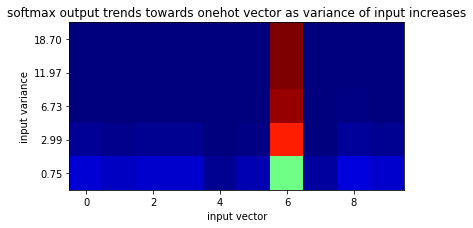

In [10]:
# high variance of weights prior to softmax is problematic, as illustrated below

# loop through scaling factors from 1 to 100 in steps of 10 and observe how the variance of the weights changes and how this effects the shape of the softmax distribution
torch.manual_seed(42) # for reproducibility

x = torch.randn(10,) 
# create range of integers from 1 to 10 with step size of 2
scale = list(range(1,6,1))[::-1]
x_scaled = torch.stack([x * i for i in scale])
vars = [var.item() for var in x_scaled.var(dim=1)]
x_softmaxes = F.softmax(x_scaled, dim=1)

# plot softmax distributions 
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots()

ax.imshow(x_softmaxes.numpy(),vmin=0,vmax=1, cmap="jet")
ax.set_yticks(range(len(vars)))
ax.set_yticklabels(["{:.2f}".format(var) for var in vars])
ax.set_xlabel('input vector')
ax.set_ylabel('input variance')
ax.set_title("softmax output trends towards onehot vector as variance of input increases")


**TANGENT: BROADCASTING AND THE IMPORANCE OF KEEPDIM**

In [11]:
# tangent: importance of using the correct setting for keepdim

wei = torch.tril(torch.ones(T, T)) # lower triangular matrix (T, T)

sum_incorrect = wei.sum(1) # keepdim=False by default; output is row vector (T)
sum_correct = wei.sum(1, keepdim=True) # output is column vector (T, 1)

print(f'{sum_incorrect.shape = }')
print(f'{sum_correct.shape = }')

print(f'{sum_incorrect = }')
print(f'{sum_correct = }')

sum_incorrect.shape = torch.Size([8])
sum_correct.shape = torch.Size([8, 1])
sum_incorrect = tensor([1., 2., 3., 4., 5., 6., 7., 8.])
sum_correct = tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.]])


during wei = wei / sum, the following will happen:

*for sum_incorrect:*

(T, T) / (T)

(T, T) / ( , T) shift to the right

(T, T) / (T, T) duplicate *row* vector down all the columns -- WRONG!


*for sum_correct:*

(T, T) / (T, 1) 

(T, T) / (T, T) duplicate *column* vector across all the rows -- CORRECT!